## Air Quality Dashboard
This notebook shows how to use IPython Widgets to display the air quality using Grove Sensors.

To install the correct serial and I2C libraries use:

`pip install pyserial smbus`

The dashboard can be run with the code cells hidden by using **`jupyter_dashboards`**. You can install and enable it with the following commands:

`pip install jupyter_dashboards`

`jupyter dashboards quick-setup --sys-prefix`

You can show the full notebook again using the View Menu -> Notebook

In [1]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.animation import FuncAnimation
import collect_air_data
import time
from datetime import datetime
import pandas as pd
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import Button, HBox, VBox
import os

air_data = collect_air_data.collect_air_object()
#Manage relative values of PMS here
pms_ref_0_3 = air_data.pms_ref_0_3
pms_ref_0_5 = air_data.pms_ref_0_5
pms_ref_1_0 = air_data.pms_ref_1_0

#Make a CSV Data folder
try:
    os.makedirs("CSV-Data")
except OSError:
    pass

In [2]:
#This cell make sure the bme680 is heated up
while True:
    if air_data.bme_680.get_sensor_data():
        output = '{0:.2f} C,{1:.2f} hPa,{2:.2f} %RH'.format(
            air_data.bme_680.data.temperature,
            air_data.bme_680.data.pressure,
            air_data.bme_680.data.humidity)
        #Only print gas data if the heater is stable
        if air_data.bme_680.data.heat_stable:
            print('{0},{1} Ohms'.format(
                output,
                air_data.bme_680.data.gas_resistance))
            break
        else:
            print(output)
    time.sleep(1)

30.65 C,1011.92 hPa,32.29 %RH
30.66 C,1011.94 hPa,32.27 %RH
30.66 C,1011.93 hPa,32.29 %RH
30.67 C,1011.92 hPa,32.27 %RH
30.69 C,1011.93 hPa,32.25 %RH,57823.27861505574 Ohms


In [3]:
button = widgets.Button(description='Reset Values to 1')
def on_button_clicked(_):
    air_data.reset_ref_values()
    #Reset all the reference values to their current value
    pms5003_data = air_data.pms5003.read()
    pms_ref_0_3 = pms5003_data.pm_per_1l_air(0.3)
    pms_ref_0_5 = pms5003_data.pm_per_1l_air(0.5)
    pms_ref_1_0 = pms5003_data.pm_per_1l_air(1.0)
# linking button and function together using a button's method
button.on_click(on_button_clicked)

button2 = widgets.Button(description='Clear and Restart Plot')
def on_button2_clicked(_):
    global df
    df = pd.DataFrame()
# linking button and function together using a button's method
button.on_click(on_button_clicked)
button2.on_click(on_button2_clicked)

# displaying button
HBox([button,button2])

A Jupyter Widget

In [4]:
df = pd.DataFrame() #Create an empty data frame to append to later
clean_data_table = pd.DataFrame() #Create an empty data frame to append to later
clean_data_table['Analog Temperature (oC)'] = [air_data.analog_temp()]
clean_data_table['Analog VOC in Air'] = [air_data.analog_voc_ratio()]
clean_data_table['Analog Alcohol in Air'] = [air_data.analog_alcohol_ratio()]
bme_680_latest = air_data.bme_680.get_sensor_data()
clean_data_table['Digital Temperature (oC)'] = [bme_680_latest.temperature]
clean_data_table['Air Pressure (hPa)'] = [bme_680_latest.pressure]
clean_data_table['BM680 VOC'] = [bme_680_latest.gas_rel]
clean_data_table['Humidity %'] = [bme_680_latest.humidity]
clean_data_table['GM102B VOC'] = [air_data.GM102B_ratio()]
clean_data_table['GM302B VOC'] = [air_data.GM302B_ratio()]
clean_data_table['GM502B VOC'] = [air_data.GM502B_ratio()]
clean_data_table['GM702B VOC'] = [air_data.GM702B_ratio()]
pms5003_data = air_data.pms5003.read()
clean_data_table['0.3um in 0.1L air'] = [pms5003_data.pm_per_1l_air(0.3)]
clean_data_table['0.5um in 0.1L air'] = [pms5003_data.pm_per_1l_air(0.5)]
clean_data_table['1.0um in 0.1L air'] = [pms5003_data.pm_per_1l_air(1.0)]

df = df.append(clean_data_table, ignore_index = True)
    
voc_bar = widgets.widgets.FloatProgress(
    value=df.iloc[-1]['Analog VOC in Air'],
    min=0,
    max=5.0,
    description='Analog VOC:',
    bar_style='info',
    style={'bar_color': '#fcdb03'},
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

humidity_slider = widgets.FloatSlider(
    value=df.iloc[-1]['Humidity %'],
    min=0,
    max=100.0,
    step=0.1,
    description='Humidity %:',
    disabled=True,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f'
)

bm680_bar = widgets.widgets.FloatProgress(
    value=df.iloc[-1]['BM680 VOC'],
    min=0,
    max=4.0,
    description='BM680 VOC:',
    bar_style='info',
    style={'bar_color': '#4ba329'},
    orientation='horizontal'
)

temp_slider = widgets.FloatSlider(
    value=df.iloc[-1]['Analog Temperature (oC)'],
    min=0,
    max=36.0,
    step=0.1,
    description='A Temp (oC):',
    disabled=True,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f'
)
alcohol_bar = widgets.widgets.FloatProgress(
    value=df.iloc[-1]['Analog Alcohol in Air'],
    min=0,
    max=4.0,
    description='An. Alcohol:',
    bar_style='info',
    style={'bar_color': '#69fffc'},
    orientation='horizontal'
)

d_temp_slider = widgets.FloatSlider(
    value=df.iloc[-1]['Digital Temperature (oC)'],
    min=0,
    max=36.0,
    step=0.1,
    description='D Temp (oC):',
    disabled=True,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f'
)

gm102b_bar = widgets.widgets.FloatProgress(
    value=df.iloc[-1]['GM102B VOC'],
    min=0,
    max=4.0,
    description='GM102B:',
    bar_style='info',
    style={'bar_color': '#4278f5'},
    orientation='horizontal'
)

zero_3_um_slider = widgets.FloatSlider(
    value=df.iloc[-1]['0.3um in 0.1L air'],
    min=0,
    max=1000.0,
    step=0.1,
    description='0.3um Part.:',
    disabled=True,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f'
)

gm302b_bar = widgets.widgets.FloatProgress(
    value=df.iloc[-1]['GM302B VOC'],
    min=0,
    max=4.0,
    description='GM302B:',
    bar_style='info',
    style={'bar_color': '#42a4f5'},
    orientation='horizontal'
)

zero_5_um_slider = widgets.FloatSlider(
    value=df.iloc[-1]['0.5um in 0.1L air'],
    min=0,
    max=1000.0,
    step=0.1,
    description='0.5um Part.:',
    disabled=True,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f'
)

gm502b_bar = widgets.widgets.FloatProgress(
    value=df.iloc[-1]['GM502B VOC'],
    min=0,
    max=4.0,
    description='GM502B:',
    bar_style='info',
    style={'bar_color': '#42bcf5'},
    orientation='horizontal'
)

one_um_slider = widgets.FloatSlider(
    value=df.iloc[-1]['1.0um in 0.1L air'],
    min=0,
    max=1000.0,
    step=0.1,
    description='1.0um Part.:',
    disabled=True,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f'
)

gm702b_bar = widgets.widgets.FloatProgress(
    value=df.iloc[-1]['GM702B VOC'],
    min=0,
    max=5.0,
    description='GM702B:',
    bar_style='info',
    style={'bar_color': '#42d4f5'},
    orientation='horizontal'
)

pressure_slider = widgets.FloatSlider(
    value=df.iloc[-1]['Air Pressure (hPa)'],
    min=0,
    max=1200.0,
    step=0.1,
    description='Press. (hPa):',
    disabled=True,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f'
)

<IPython.core.display.Javascript object>


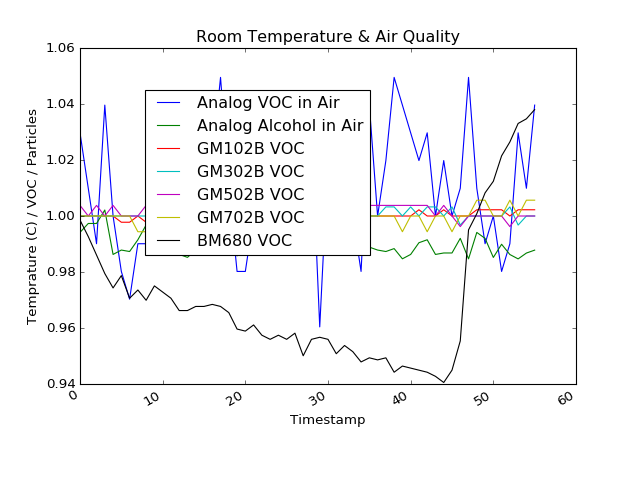

A Jupyter Widget

In [5]:
df = pd.DataFrame() #Create an empty data frame to append to later
def animate(i):
    global df
    clean_data_table = pd.DataFrame() #Create an empty data frame to append to later
    clean_data_table['Analog Temperature (oC)'] = [air_data.analog_temp()]
    clean_data_table['Analog VOC in Air'] = [air_data.analog_voc_ratio()]
    clean_data_table['Analog Alcohol in Air'] = [air_data.analog_alcohol_ratio()]
    clean_data_table['GM102B VOC'] = [air_data.GM102B_ratio()]
    clean_data_table['GM302B VOC'] = [air_data.GM302B_ratio()]
    clean_data_table['GM502B VOC'] = [air_data.GM502B_ratio()]
    clean_data_table['GM702B VOC'] = [air_data.GM702B_ratio()]
    bme_680_latest = air_data.bme_680.get_sensor_data()
    clean_data_table['Digital Temperature (oC)'] = [bme_680_latest.temperature]
    clean_data_table['Air Pressure (hPa)'] = [bme_680_latest.pressure]
    clean_data_table['Humidity %'] = [bme_680_latest.humidity]
    if bme_680_latest.heat_stable:
        clean_data_table['BM680 VOC'] = [bme_680_latest.gas_rel]
    
    #Particle sensor not plotted for this example
    pms5003_data = air_data.pms5003.read()
    clean_data_table['0.3um in 0.1L air'] = [pms5003_data.pm_per_1l_air(0.3)]
    clean_data_table['0.5um in 0.1L air'] = [pms5003_data.pm_per_1l_air(0.5)]
    clean_data_table['1.0um in 0.1L air'] = [pms5003_data.pm_per_1l_air(1.0)]
    df = df.append(clean_data_table, ignore_index = True)
    df.index.name = 'timestamp'
    
    voc_bar.value = df.iloc[-1]['Analog VOC in Air']
    humidity_slider.value = df.iloc[-1]['Humidity %']
    bm680_bar.value = df.iloc[-1]['BM680 VOC']
    temp_slider.value = df.iloc[-1]['Analog Temperature (oC)']
    alcohol_bar.value = df.iloc[-1]['Analog Alcohol in Air']
    d_temp_slider.value = df.iloc[-1]['Digital Temperature (oC)']
    gm102b_bar.value = df.iloc[-1]['GM102B VOC']
    gm302b_bar.value = df.iloc[-1]['GM302B VOC']
    gm502b_bar.value = df.iloc[-1]['GM502B VOC']
    gm702b_bar.value = df.iloc[-1]['GM702B VOC']
    zero_3_um_slider.value = df.iloc[-1]['0.3um in 0.1L air']
    zero_5_um_slider.value = df.iloc[-1]['0.5um in 0.1L air']
    one_um_slider.value = df.iloc[-1]['1.0um in 0.1L air']
    pressure_slider.value = df.iloc[-1]['Air Pressure (hPa)']
    
    x = df.index
    y1 = df['Analog VOC in Air']
    y2 = df['Analog Alcohol in Air']
    y3 = df['GM102B VOC']
    y4 = df['GM302B VOC']
    y5 = df['GM502B VOC']
    y6 = df['GM702B VOC']
    y7 = df['BM680 VOC']
    
#    y8 = df['0.3um in 0.1L air']
#    y9 = df['0.5um in 0.1L air']
#    y10 = df['1.0um in 0.1L air']
    
    plt.cla()
    plt.plot(x,y1,label='Analog VOC in Air')
    plt.plot(x,y2,label='Analog Alcohol in Air')
    plt.plot(x,y3,label='GM102B VOC')
    plt.plot(x,y4,label='GM302B VOC')
    plt.plot(x,y5,label='GM502B VOC')
    plt.plot(x,y6,label='GM702B VOC')
    plt.plot(x,y7,label='BM680 VOC')
#    plt.plot(x,y8,label='0.3um in 0.1L air')
#    plt.plot(x,y9,label='0.5um in 0.1L air')
#    plt.plot(x,y10,label='1.0um in 0.1L air')
    
    plt.xlabel('Timestamp')
    plt.ylabel('Temprature (C) / VOC / Particles')
    plt.title("Room Temperature & Air Quality")
    plt.gcf().autofmt_xdate()
    plt.ticklabel_format(useOffset=False,axis='y')
    plt.legend(bbox_to_anchor=(0.6, 0.9))
    plt.show()
    
ani = FuncAnimation(plt.gcf(), animate,interval=2000)
plt.show()

first_box = HBox([voc_bar, humidity_slider])
second_box = HBox([bm680_bar, temp_slider])
third_box = HBox([alcohol_bar, d_temp_slider])
fourth_box = HBox([gm102b_bar, zero_3_um_slider])
fifth_box = HBox([gm302b_bar, zero_5_um_slider])
sixth_box = HBox([gm502b_bar, one_um_slider])
seventh_box = HBox([gm702b_bar, pressure_slider])
VBox([first_box, second_box, third_box, fourth_box, fifth_box,sixth_box, seventh_box])

In [6]:
#Show the last row of the data table
df.tail(1)

""


In [7]:
#Save the data frame to a CSV file
df.index.name = 'timestamp'
filename = "CSV-Data/Fresh Air" + str(datetime.now()) + ".csv"
df.to_csv(filename)